In [ ]:
#import packages
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import datasets

In [ ]:
#link to google drive
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('drive/My Drive/course/bioinfo590/project_study/data')

Mounted at /content/drive/


In [ ]:

os.listdir()

['DNASE.HepG2.conservative.narrowPeak.gz',
 'DNASE.H1-hESC.conservative.narrowPeak.gz',
 'DNASE.K562.conservative.narrowPeak.gz',
 'ATF3.meme',
 'final_with_all_data_sep.bed',
 'H1_chr10_ATF3.bed.gz',
 'K562_chr11_ATF3.bed.gz',
 'H1_chr11_ATF3.bed.gz',
 'K562_chr10_ATF3.bed.gz']

In [ ]:
input_big_matrix1=pd.read_csv("H1_chr10_ATF3.bed.gz",sep='\t',header=None,compression='gzip')
input_big_matrix2=pd.read_csv("H1_chr11_ATF3.bed.gz",sep='\t',header=None,compression='gzip')
input_big_matrix3=pd.read_csv("K562_chr11_ATF3.bed.gz",sep='\t',header=None,compression='gzip')
input_big_matrix4=pd.read_csv("K562_chr10_ATF3.bed.gz",sep='\t',header=None,compression='gzip')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
input_big_matrix=pd.concat([input_big_matrix1,input_big_matrix2,input_big_matrix3,input_big_matrix4])

In [ ]:
input_big_matrix=input_big_matrix.replace("NAN",np.nan)

In [ ]:
input_big_matrix.dropna(thresh=5)

,0,1,2,3,4,5,6,7,8
0,chr10,600,800,U,NaN,NaN,0,NaN,NaN
1,chr10,650,850,U,NaN,NaN,0,NaN,NaN
2,chr10,700,900,U,NaN,NaN,0,NaN,NaN
3,chr10,750,950,U,NaN,NaN,0,NaN,NaN
4,chr10,800,1000,U,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2702278,chr10,135524550,135524750,U,0.000000,0.000000,0.359970,0.293914,NaN
2702279,chr10,135524600,135524800,U,NaN,NaN,0.479960,0.207829,NaN
2702280,chr10,135524650,135524850,U,NaN,NaN,0.539955,0.254537,NaN
2702281,chr10,135524700,135524900,U,NaN,NaN,0.539955,0.254537,NaN


In [ ]:
input_big_matrix=input_big_matrix.replace(np.nan,0)

In [ ]:
input_big_matrix

,0,1,2,3,4,5,6,7,8
0,chr10,600,800,U,0,0,0,0,0
1,chr10,650,850,U,0,0,0,0,0
2,chr10,700,900,U,0,0,0,0,0
3,chr10,750,950,U,0,0,0,0,0
4,chr10,800,1000,U,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2702465,chr10,135533900,135534100,U,0,0,0,0,0
2702466,chr10,135533950,135534150,U,0,0,0,0,0
2702467,chr10,135534000,135534200,U,0,0,0,0,0
2702468,chr10,135534050,135534250,U,0,0,0,0,0


In [ ]:
# #only kept 1% of the U to avoid overfitting
# other_than_U=input_big_matrix[input_big_matrix[3]!="U"]
# U_part=input_big_matrix[input_big_matrix[3]=="U"]
# rand_index1=np.random.rand(sum(input_big_matrix[3]=="U"))
# kept_U_part=U_part[rand_index1>=0.99]
# part_of_the_training=pd.concat([kept_U_part,other_than_U])
# input_big_matrix=part_of_the_training

In [ ]:
#read training_data
training_matrix1=np.matrix(input_big_matrix.iloc[:,4:9])
training_label1=np.matrix(input_big_matrix.iloc[:,3])
training_label1[training_label1=="U"]=0
training_label1[training_label1=="B"]=1
training_label1[training_label1=="A"]=2


In [ ]:
#no overlap dealing with
training_matrix_subset=training_matrix1[::4,:]
training_label_subset=training_label1[:,::4]
if training_matrix_subset.shape[0]%10!=0:
  training_matrix_subset=training_matrix_subset[0:-(training_matrix_subset.shape[0]%10),:]
  training_label_subset=training_label_subset[:,0:-(training_label_subset.shape[1]%10)]
else:
  print('jump')
training_matrix_subset=training_matrix_subset.reshape(int(len(training_matrix_subset)/10),50)
training_label_subset=training_label_subset[:,2::5]
training_matrix=training_matrix_subset
training_label=training_label_subset

In [ ]:
sum(argmaxtraining_label_torch.shape)

537489

In [ ]:
training_matrix=training_matrix1
training_label=training_label1

In [ ]:
#change into torch format
training_label=np.eye(3)[training_label.astype(np.int32)]
training_matrix_torch=torch.FloatTensor(training_matrix.astype(np.float64))
training_label_torch=torch.FloatTensor(training_label.astype(np.int32))
training_label_torch=training_label_torch.cuda()
training_matrix_torch=training_matrix_torch.cuda()


RuntimeError: ignored

In [ ]:
train[1*100:1*200].shape

torch.Size([100, 5])

In [ ]:
#sep into training and testing
rand_index=np.random.rand(len(training_matrix_torch))
train=training_matrix_torch[rand_index<0.8]
test=training_matrix_torch[rand_index>=0.8]
train_label=training_label_torch[0,rand_index<0.8]
test_label=training_label_torch[0,rand_index>=0.8]


In [ ]:
# ###seperate the training,validation,test
# training_size=int(0.8*len(training_matrix))
# validation_size=int(0.1*len(training_matrix))
# test_size=len(training_matrix)-training_size-validation_size

In [ ]:
# train_dataset,validation_dataset,test_dataset = torch.utils.data.random_split(training_matrix, [training_size, validation_size,test_size])


In [1]:
# class resblock(nn.Module):
#   def __init__(self):
#     super(resblock,self).__init__()
#     self.cov1=nn.Conv1d(32,32,3,padding=1)
#     self.bn1=nn.InstanceNorm1d(32)
#     self.cov2=nn.Conv1d(32,32,3,padding=1)
#     self.bn2=nn.InstanceNorm1d(32)

#   def forward(self,x):
#     residual=x
#     x=self.cov1(x)
#     x=self.bn1(x)
#     x=F.relu(x)
#     x=self.cov2(x)
#     x=self.bn2(x)
#     x=x+residual
#     x=F.relu(x)
#     return x



In [ ]:
class Net(nn.Module):
  def __init__(self):

    super(Net,self).__init__()
    self.fc1=nn.Linear(5,100)
    self.fc2=nn.Linear(100,200)
    self.fc3=nn.Linear(200,3)

  def forward(self,x):
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=F.relu(self.fc3(x)

    output=F.log_softmax(x,dim=1)
    return output


net=Net()
print(net)

Net(
  (cov1): Conv1d(6, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (res1): Sequential(
    (0): resblock(
      (cov1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (cov2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (1): resblock(
      (cov1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (cov2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
  )
  (cov2): Conv1d(32, 3, kernel_size=(3,), stride=(1,), padding=(1,))

In [ ]:


optimizer = torch.optim.Adam(net.parameters(), weight_decay=0.001,lr=0.01)


(2, 6400, 6)

In [ ]:
batch_size=1
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(len(train)//batch_size):
      input=train[i*batch_size:i*batch_size+batch_size]
      label=train_label[i*batch_size:i*batch_size+batch_size]
      optimizer.zero_grad()
      outputs = net(input)
      loss=torch.sum(-(outputs*label))
      #test new loss function
      #loss1 = nn.NLLLoss()
      #loss=loss1(outputs,torch.argmax(label,dim=1))
      loss.backward()
      optimizer.step()
      running_loss=running_loss+loss.item()
    print(epoch,running_loss/len(train))
    test_predict=net(test)
    
    #roc_auc_score_1=roc_auc_score(test_predict.cpu(),test.cpu())
    test_accuracy=(torch.argmax(test_predict,dim=1)==torch.argmax(test_label,dim=1)).float().mean()
    #print(roc_auc_score_1)
    print(test_accuracy)

print('Finished Training')

0 -0.8449804928394264
tensor(0.5730, device='cuda:0')
1 -0.7483833651961992
tensor(0.5730, device='cuda:0')
2 -0.5706215685590487
tensor(0.5730, device='cuda:0')
3 -0.7901898741725948
tensor(0.5730, device='cuda:0')
4 -0.7914074996505657
tensor(0.5730, device='cuda:0')
5 -0.7956531874632471
tensor(0.5730, device='cuda:0')
6 -0.48562113189605605
tensor(0.5730, device='cuda:0')
7 -0.5706242871657112
tensor(0.5730, device='cuda:0')
8 -0.5221684404959761
tensor(0.5730, device='cuda:0')
9 -0.5706235813906887
tensor(0.5730, device='cuda:0')
Finished Training


In [ ]:
test_predict_fromdp1=test_predict.cpu().detach().numpy()

In [ ]:
test_label_fromdp1=test_label.cpu().numpy()

In [ ]:
##auc-roc 
n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_label_fromdp1[:, i], test_predict_fromdp1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
roc_auc

{0: 0.5745590067191833, 1: 0.489870178579379, 2: 0.5617784579109214}

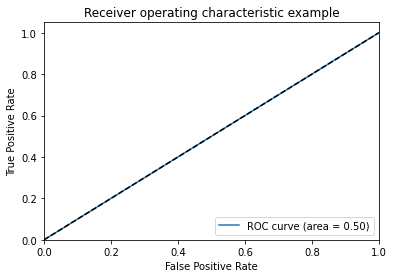

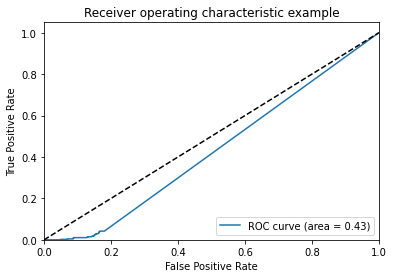

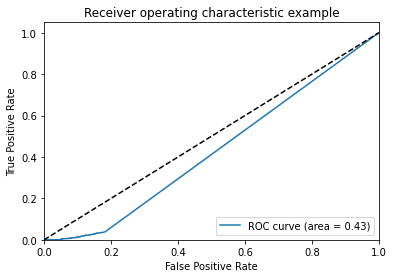

In [ ]:
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

tensor(0.5000)

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

(36011, 5)

In [ ]:
#####quickly build a random forest
>>> from sklearn.ensemble import RandomForestClassifier
>>> from sklearn.datasets import make_classification
 
>>> clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(train.cpu().numpy(),torch.argmax(train_label,dim=1).cpu().numpy())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
random_forest_model=clf.predict(test.cpu().numpy())
random_forest_model_y_score=clf.predict_proba(test.cpu().numpy())
temp_test_label=test_label.cpu().numpy()

In [ ]:
n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(temp_test_label[:, i], random_forest_model_y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
roc_auc

{0: 0.8300118637989473, 1: 0.8494346552099246, 2: 0.8073529845725549}

In [ ]:
random_forest_model

array([0, 0, 0, ..., 0, 0, 0])

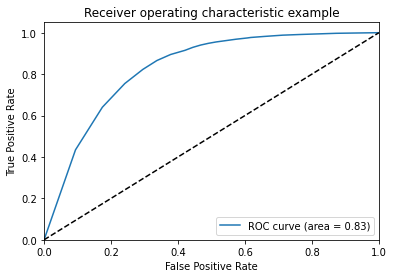

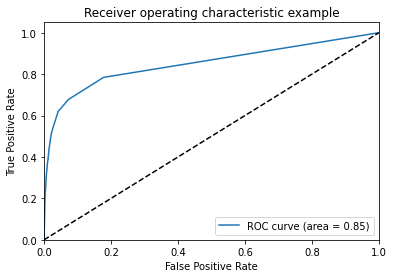

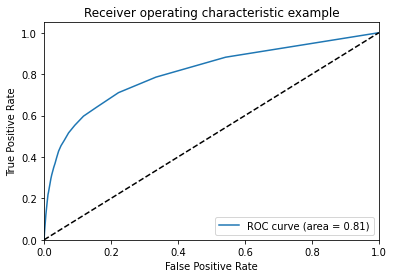

In [ ]:
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()